# Packages

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from osgeo import gdal
from sklearn import preprocessing

%matplotlib inline
from IPython.display import Image
from PIL import Image

# Functions

In [5]:
# georeferenced tiff image is inputted. width and height become latitude and longitude, and each of the three RGB channels are pulled out
def xyz_geotiff(img):
    band_r = img.GetRasterBand(1) # retrieves the red layer 
    z_r = np.flipud(band_r.ReadAsArray()).T

    band_g = img.GetRasterBand(2) # retrieves the green layer 
    z_g = np.flipud(band_g.ReadAsArray()).T

    band_b = img.GetRasterBand(3) # retrieves the blue layer 
    z_b = np.flipud(band_b.ReadAsArray()).T
    
    width = img.RasterXSize 
    height = img.RasterYSize 
    
    gt = img.GetGeoTransform()                        

    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]

    # create linearly spaced arrays of lat and lon values where the length of the array is equal to the width or height of the image
    lon = np.linspace(minx,maxx,width)  
    lat = np.linspace(miny,maxy,height) 
    
    return lon,lat,z_r,z_g,z_b # returns the lat, lon, and red, green, blue values in arrays

In [6]:
# function to return the maximum and minimum values in an array that excludes NaN values
def maxmin(array): 
    max = np.nanmax(array)
    min = np.nanmin(array)
    return max,min

In [7]:
# initial function that tried to scale data between 0 and 100
def scale(array):
    scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
    scaled = scaler.fit_transform(array)
    
    return scaled

In [8]:
# function to scale data between 0 and 100
def scalenan(array):
    nan_values = np.isnan(array) # checks for nan values in the array
    array[nan_values] = 0 # replaces the nan values with 0
    
    scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
    scalednan = scaler.fit_transform(array) 

    array[nan_values] = np.nan # returns replaced 0 values back a nan value in old array
    scalednan[nan_values] = np.nan # returns replaced 0 values back a nan value in new array
    
    return scalednan

In [9]:
# function to normalise data between 0 and 100
def normalise(array):
    normalise = (array - maxmin(array)[1]) / (maxmin(array)[0] - maxmin(array)[1]) * 100
    return normalise

In [10]:
#function that extracts the gibber percent cover based on the relationship between two bands and a pre-defined threshold value
def gibpercent(band1,band2,threshold,nan=True):
    multi = band1 * band2

    multi_norm = normalise(multi)
    multi_norm[multi_norm<threshold] = 0

    if nan:
        copy = np.copy(multi_norm)
        copy[copy<threshold] = np.nan
        cut_norm = normalise(copy)

    return multi_norm, cut_norm

In [11]:
def brightgib(array,value):
    copy = np.copy(array)
    copy[copy>value] = np.nan

    new = []
    for i in copy:
        new.append((1 - i)+250)
    
    #normalise = ((copy - maxmin(copy)[1]) / (maxmin(copy)[0] - maxmin(copy)[1]) * 100)
    
    return new

# Data

In [12]:
# load in jpeg of cropped study site
img = Image.open('cropped_lowres_ortho_kalabity.jpg')

# resize
new_width = 400
new_height = 400
resized_img = img.resize((new_width, new_height))

In [13]:
# load in the pre-cropped orthomosaic file
data_geotiff = gdal.Open('cropped_10cm_ortho_kalabity.tif')  
lon_geotiff, lat_geotiff, z_r_geotiff, z_g_geotiff, z_b_geotiff = xyz_geotiff(data_geotiff) 

C:\Users\idaga\miniconda3\envs\pyigau\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [14]:
# print data to have a quick look at it
z_g_geotiff

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

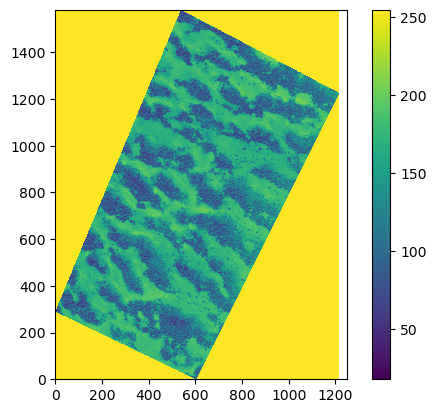

In [16]:
# quickly plot data to examine
plt.pcolormesh(z_g_geotiff.T)
plt.axis('square')
plt.xlim(0,1250)
plt.colorbar()

In [17]:
# remove values outside of the study area by converting to NaN
z_r_geotiff = z_r_geotiff.astype(float) 
z_g_geotiff = z_g_geotiff.astype(float) 
z_b_geotiff = z_b_geotiff.astype(float) 

z_r_geotiff[z_r_geotiff==255] = np.nan 
z_g_geotiff[z_g_geotiff==255] = np.nan 
z_b_geotiff[z_b_geotiff==255] = np.nan 

# Analysis 

In [18]:
# print the maximum and minimum values in each RGB channel using the previously defined maxmin function
maxmin_values = np.array([maxmin(z_r_geotiff), maxmin(z_g_geotiff), maxmin(z_b_geotiff)])
maxmin_values

array([[233.,  19.],
       [212.,  18.],
       [195.,  18.]])

In [93]:
# scale each RGB channel using the initial scaling method
scaled_r = scale(z_r_geotiff)
scaled_g = scale(z_g_geotiff)
scaled_b = scale(z_b_geotiff)

first_scale = np.array([maxmin(scaled_r),maxmin(scaled_g),maxmin(scaled_b)]) # checking that they have scaled between 0 and 100
first_scale

array([[100.,   0.],
       [100.,   0.],
       [100.,   0.]])

In [94]:
# scale each RGB channel using the second scaling method
r_scalenan = scalenan(z_r_geotiff)
g_scalenan = scalenan(z_g_geotiff)
b_scalenan = scalenan(z_b_geotiff)

second_scale = np.array([maxmin(r_scalenan),maxmin(g_scalenan),maxmin(b_scalenan)]) # checking that they have scaled between 0 and 100
second_scale

array([[100.        ,   8.44444444],
       [100.        ,   9.        ],
       [100.        ,  10.43956044]])

In [95]:
# normalise each RGB channel using the normalisation function 
r_norm = normalise(z_r_geotiff)
g_norm = normalise(z_g_geotiff)
b_norm = normalise(z_b_geotiff)

norm = np.array([maxmin(r_norm),maxmin(g_norm),maxmin(b_norm)]) # checking that they have scaled between 0 and 100
norm

array([[100.,   0.],
       [100.,   0.],
       [100.,   0.]])

In [96]:
#determine threshold for gibber percent 
multi50,cut50 = gibpercent(b_norm,r_norm,50,nan=True) # threshold value of 50
multi60,cut60 = gibpercent(b_norm,r_norm,60,nan=True) # threshold value of 60
multi70,cut70 = gibpercent(b_norm,r_norm,70,nan=True) # threshold value of 70

# Plots

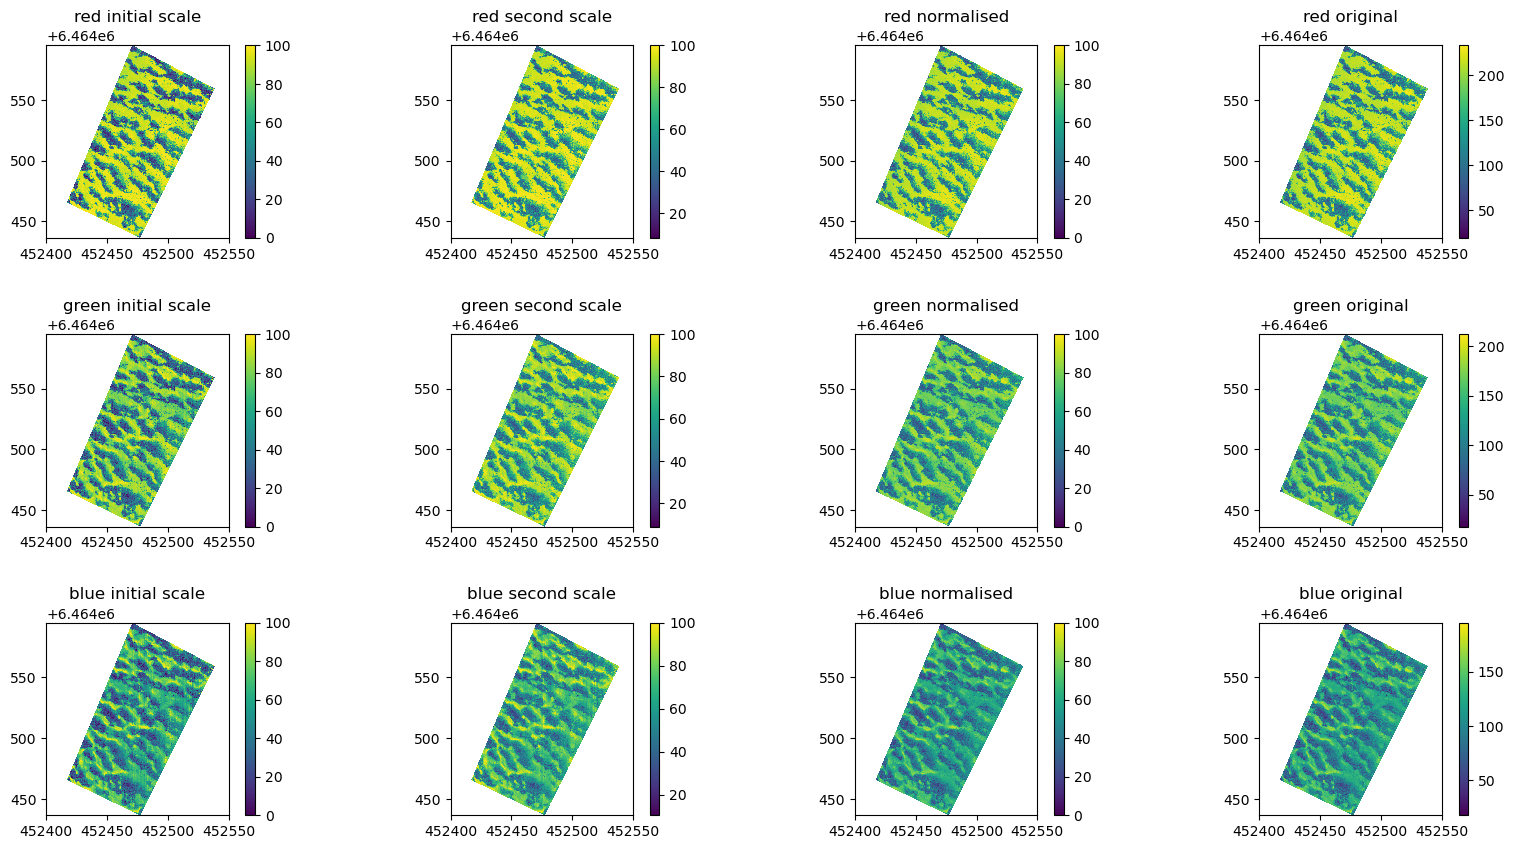

In [98]:
# plot all scaling and normalisation methods to determine the most effective way to represent the data
# decision that the normalisation is the best as it looks very similar to the original data (just on a different scale) and the scaling produces weird artefacts that aren't in the original data
fig = plt.gcf()

# red channel
plt.subplot(3,4,1)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_r)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('red initial scale')

plt.subplot(3,4,2)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_scalenan)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('red second scale')

plt.subplot(3,4,3)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_norm)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('red normalised')

plt.subplot(3,4,4)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_r_geotiff)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('red original')


# green channel
plt.subplot(3,4,5)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_g)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('green initial scale')

plt.subplot(3,4,6)
plt.pcolormesh(lon_geotiff,lat_geotiff,g_scalenan)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('green second scale')

plt.subplot(3,4,7)
plt.pcolormesh(lon_geotiff,lat_geotiff,g_norm)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('green normalised')

plt.subplot(3,4,8)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_g_geotiff)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('green original')


#blue channel
plt.subplot(3,4,9)
plt.pcolormesh(lon_geotiff,lat_geotiff,scaled_b)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('blue initial scale')

plt.subplot(3,4,10)
plt.pcolormesh(lon_geotiff,lat_geotiff,b_scalenan)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('blue second scale')

plt.subplot(3,4,11)
plt.pcolormesh(lon_geotiff,lat_geotiff,b_norm)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('blue normalised')

plt.subplot(3,4,12)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_b_geotiff)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.title('blue original')


plt.subplots_adjust(hspace=0.5,wspace=0.2)
fig.set_size_inches(20,10)

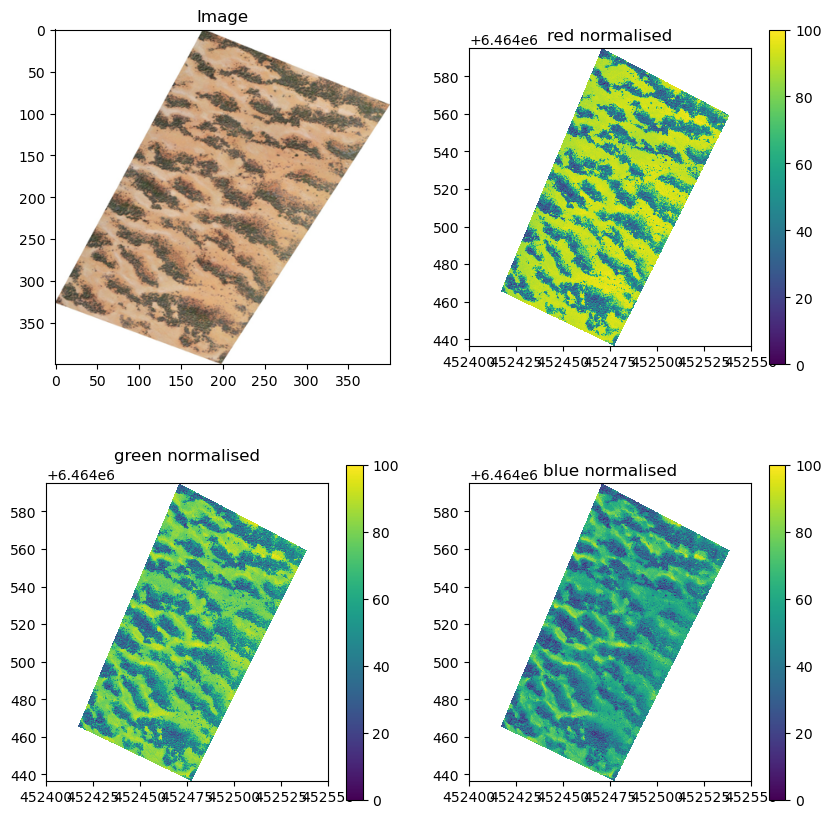

In [101]:
# comparison of each normalised plot to the jpeg to determine which represents gibber coverage best
# the green and blue channels differentiate between the gibber cover and exposed ground surface quite well. The red doesn't really at all but is good to differentiate between groves and intergroves
fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(resized_img)
axes[0, 0].set_title('Image')

im = axes[0, 1].pcolormesh(lon_geotiff,lat_geotiff,r_norm)  
axes[0, 1].set_title('red normalised')
axes[0, 1].axis('square')
axes[0, 1].set_xlim(452400,452550)
fig.colorbar(im, ax=axes[0, 1])

im = axes[1, 0].pcolormesh(lon_geotiff,lat_geotiff,g_norm)  
axes[1, 0].set_title('green normalised')
axes[1, 0].axis('square')
axes[1, 0].set_xlim(452400,452550)
fig.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].pcolormesh(lon_geotiff,lat_geotiff,b_norm)  
axes[1, 1].set_title('blue normalised')
axes[1, 1].axis('square')
axes[1, 1].set_xlim(452400,452550)
fig.colorbar(im, ax=axes[1, 1])

plt.subplots_adjust(hspace=0.3,wspace=0.2)
fig.set_size_inches(10,10)

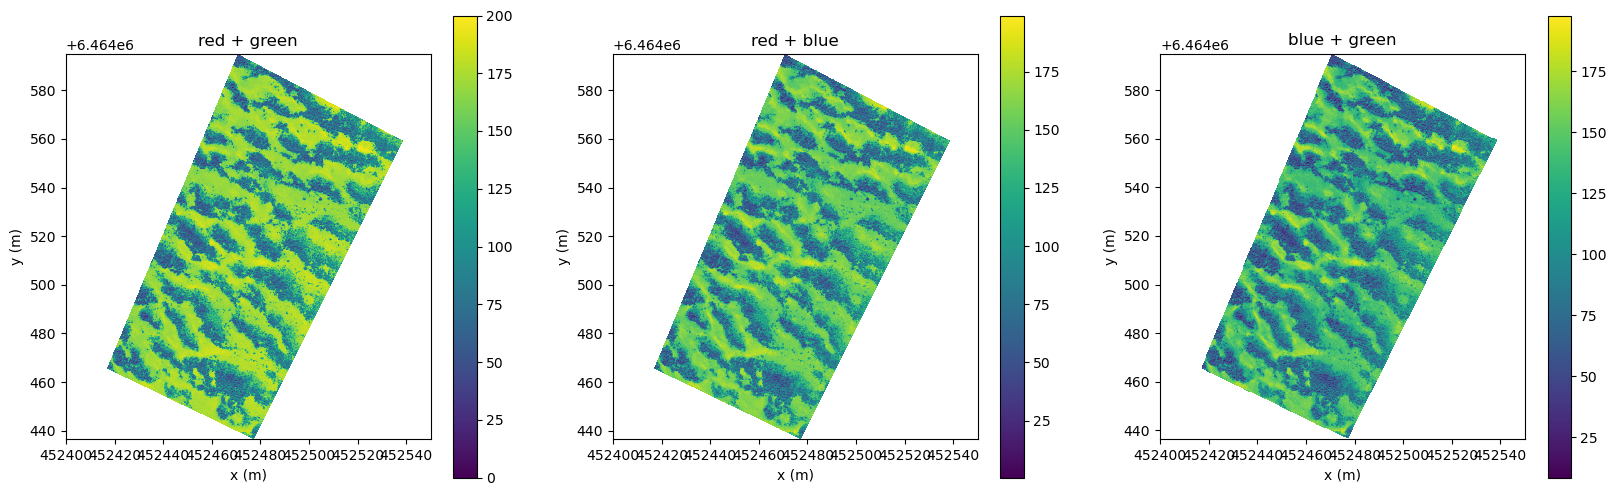

In [102]:
# plot of each combination of bands added together to see if adding green and blue is the best option. From left to right, in order of best representation

# 1 is native res
fig = plt.gcf()

plt.subplot(131)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_norm+g_norm) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red + green')

plt.subplot(132)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_norm+b_norm) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red + blue')

plt.subplot(133)
plt.pcolormesh(lon_geotiff[::4],lat_geotiff[::4],(b_norm+g_norm)[::4][:,::4]) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue + green')

plt.subplots_adjust(hspace=0.4)
fig.set_size_inches(20,6)

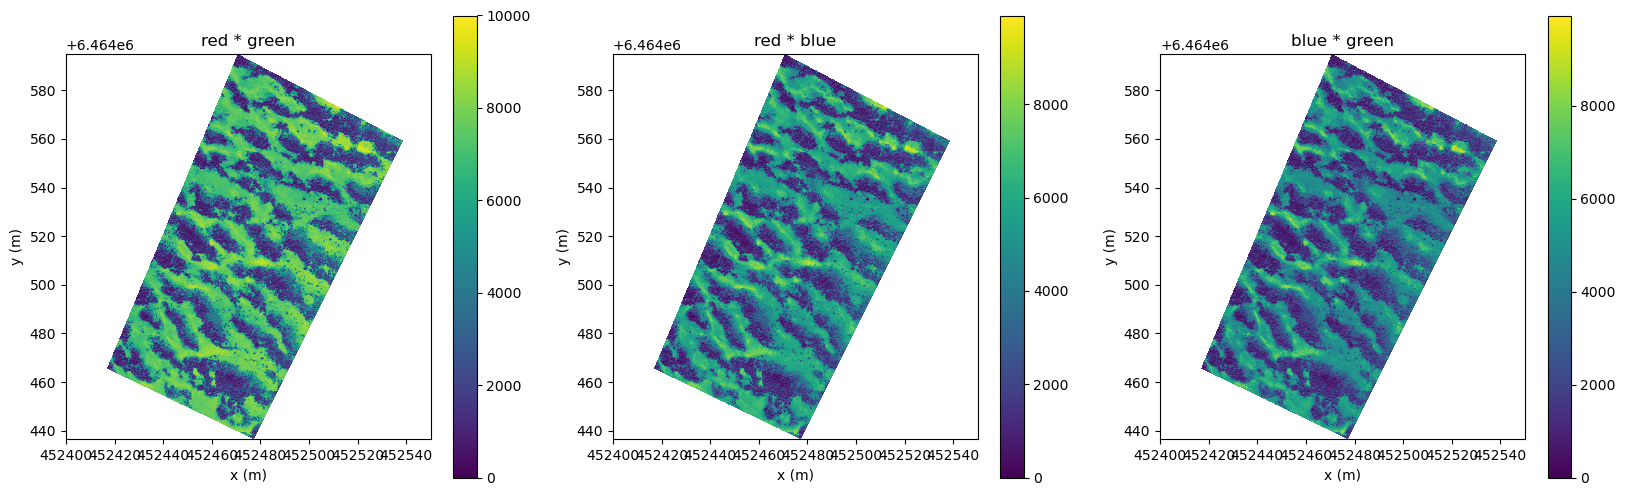

In [103]:
# plot of each combination of bands multiplied together. Interestingly we see that red * blue is the most effective
fig = plt.gcf()

plt.subplot(131)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_norm*g_norm) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red * green')

plt.subplot(132)
plt.pcolormesh(lon_geotiff,lat_geotiff,r_norm*b_norm) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('red * blue')

plt.subplot(133)
plt.pcolormesh(lon_geotiff,lat_geotiff,b_norm*g_norm) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('blue * green')

plt.subplots_adjust(hspace=0.4)
fig.set_size_inches(20,6)

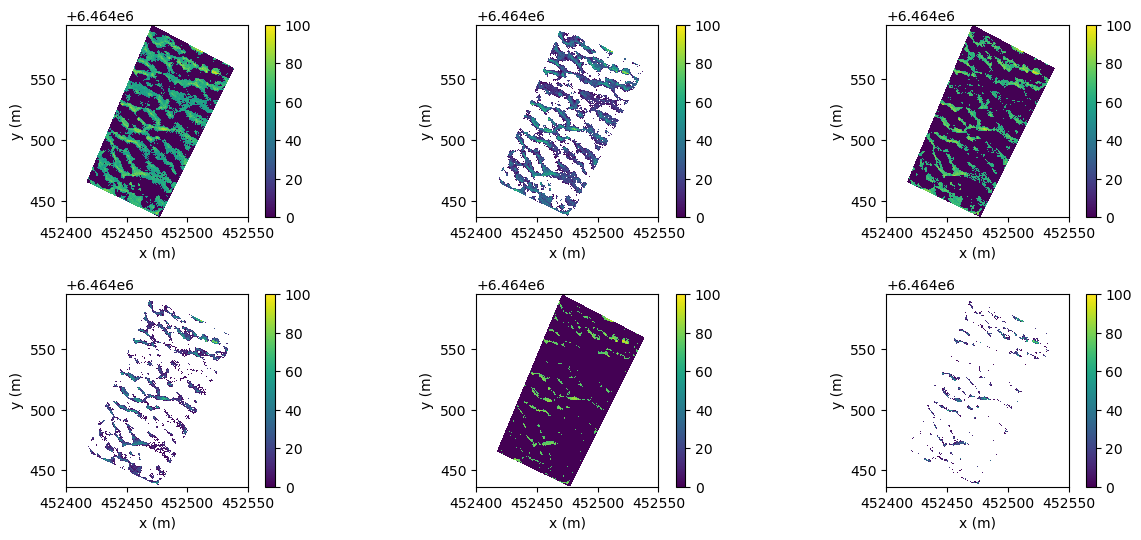

In [104]:
# plotting different thresholds to manually compare with image of the site and see which shows gibber coverage best
fig = plt.gcf()

#threshold 50
plt.subplot(231)
plt.pcolormesh(lon_geotiff,lat_geotiff,multi50) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplot(232)
plt.pcolormesh(lon_geotiff,lat_geotiff,cut50) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# threshold 60
plt.subplot(233)
plt.pcolormesh(lon_geotiff,lat_geotiff,multi60) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplot(234)
plt.pcolormesh(lon_geotiff,lat_geotiff,cut60) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# threshold 70
plt.subplot(235)
plt.pcolormesh(lon_geotiff,lat_geotiff,multi70) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplot(236)
plt.pcolormesh(lon_geotiff,lat_geotiff,cut70) 
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplots_adjust(hspace=0.4)
fig.set_size_inches(15,6)

In [19]:
def process_geotiff(array):
    bright_255 = []
    for i in array:
        bright_255.append(255 - i)
    return bright_255

In [20]:
r = np.array(process_geotiff(z_r_geotiff))
g = np.array(process_geotiff(z_g_geotiff))
b = np.array(process_geotiff(z_b_geotiff))

In [21]:
def brightness(red, green, blue):
    return red + green + blue

In [22]:
take1 = brightness(r,g,b)

take3 = brightness(z_r_geotiff,z_g_geotiff,z_b_geotiff)

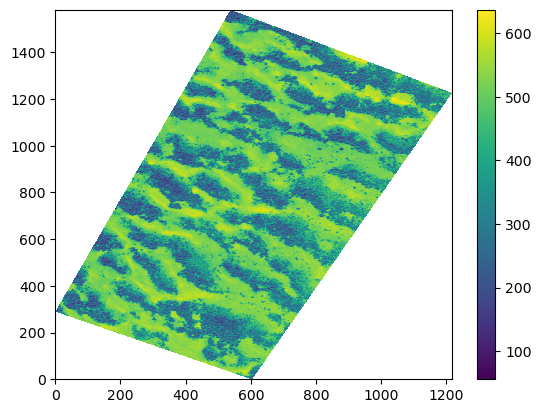

In [24]:
plt.pcolormesh(take3.T)
plt.colorbar()

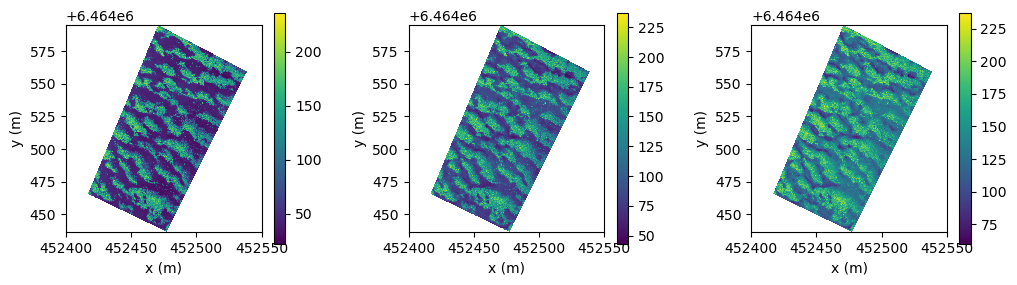

In [110]:
fig = plt.gcf()

plt.subplot(131)
plt.pcolormesh(lon_geotiff, lat_geotiff,r)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplot(132)
plt.pcolormesh(lon_geotiff, lat_geotiff,g)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplot(133)
plt.pcolormesh(lon_geotiff, lat_geotiff,b)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplots_adjust(wspace=0.4)
fig.set_size_inches(12,3)

In [111]:
take2 = brightgib(take1, 250)

In [112]:
np.shape(take1)

(1583, 1217)

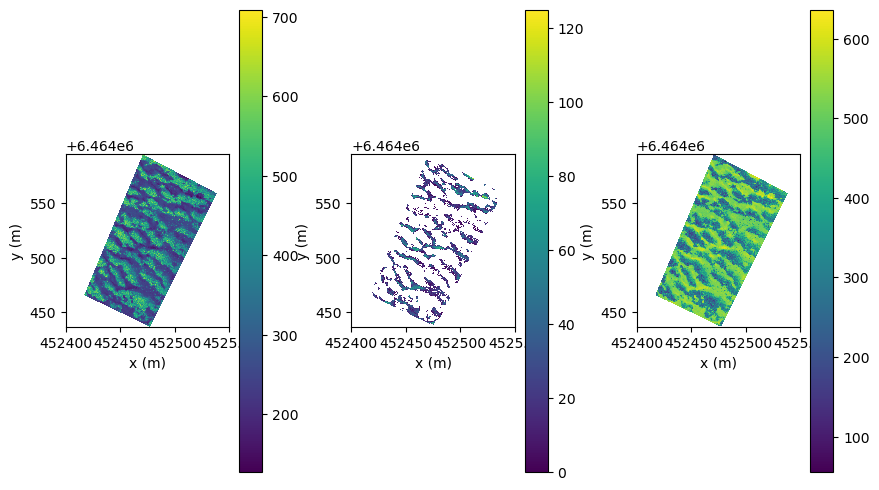

In [113]:
# plot of all brightness plots added together and lower numbers correlate well with gibber coverage
fig = plt.gcf()

plt.subplot(131)
plt.pcolormesh(lon_geotiff, lat_geotiff,take1)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplot(132)
plt.pcolormesh(lon_geotiff, lat_geotiff, take2, cmap='viridis',vmin=0,vmax=125)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplot(133)
plt.pcolormesh(lon_geotiff, lat_geotiff, take3, cmap='viridis')
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplots_adjust(wspace=0.4)
fig.set_size_inches(10,6)

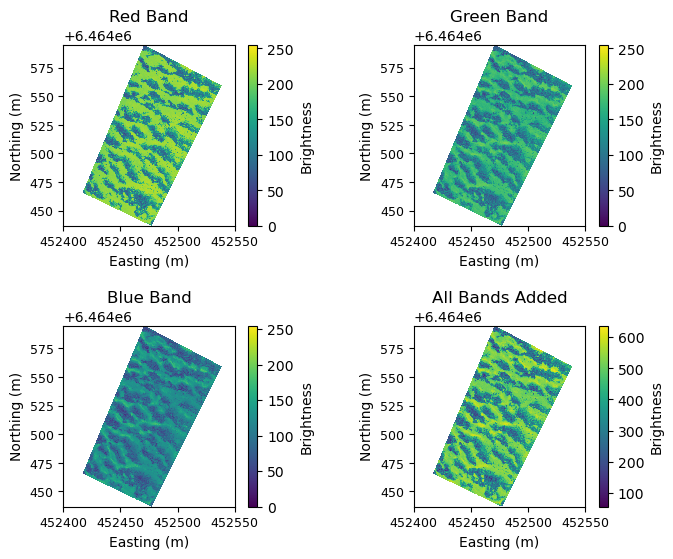

In [114]:
# initial plots of each colour band
fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_r_geotiff,vmin=0,vmax=255) 
plt.axis('square')
plt.xlim(452400,452550)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.colorbar(label='Brightness')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Red Band')

plt.subplot(222)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_g_geotiff,vmin=0,vmax=255) 
plt.axis('square')
plt.xlim(452400,452550)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.colorbar(label='Brightness')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Green Band')

plt.subplot(223)
plt.pcolormesh(lon_geotiff,lat_geotiff,z_b_geotiff,vmin=0,vmax=255) 
plt.axis('square')
plt.xlim(452400,452550)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.colorbar(label='Brightness')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Blue Band')

plt.subplot(224)
plt.pcolormesh(lon_geotiff, lat_geotiff, take3)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar(label='Brightness')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('All Bands Added')

plt.subplots_adjust(hspace=0.55,wspace=0.3)
fig.set_size_inches(8,6)

plt.savefig('initial_plots_each_band',dpi=300)

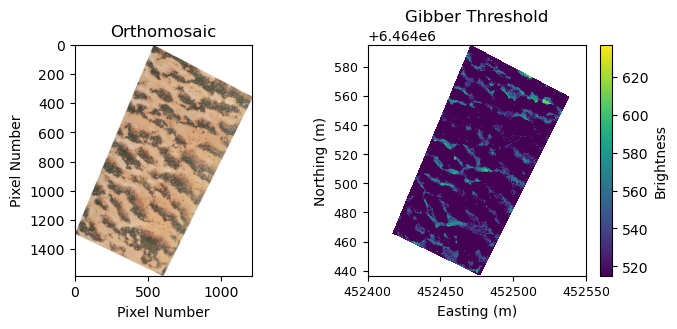

In [126]:
fig, axes = plt.subplots(1,2)

axes[0].imshow(img)
axes[0].set_title('Orthomosaic')
axes[0].set_xlabel('Pixel Number')
axes[0].set_ylabel('Pixel Number')

im = axes[1].pcolormesh(lon_geotiff,lat_geotiff,take3,vmin=515)  
axes[1].set_title('Gibber Threshold')
axes[1].set_xlabel('Easting (m)')
axes[1].set_ylabel('Northing (m)')
axes[1].axis('square')
axes[1].set_xlim(452400,452550)
axes[1].tick_params(axis='both', which='major', labelsize=9)
colorbar = fig.colorbar(im, ax=axes[1])
colorbar.set_label('Brightness')

#plt.subplots_adjust(hspace=0.5)
fig.set_size_inches(8,3)

plt.savefig('gibber_bright_threshold',dpi=300)

In [25]:
def brightgib(array,value):
    copy = np.copy(array)
    copy[copy<value] = np.nan
    return copy

def zerogib(array,value):
    copy = np.copy(array)
    copy[copy<value] = 0
    return copy

In [26]:
isolate46 = brightgib(take3,460)
zero46 = zerogib(take3,460)

isolate20 = brightgib(take3,520)
zero20 = zerogib(take3,520)

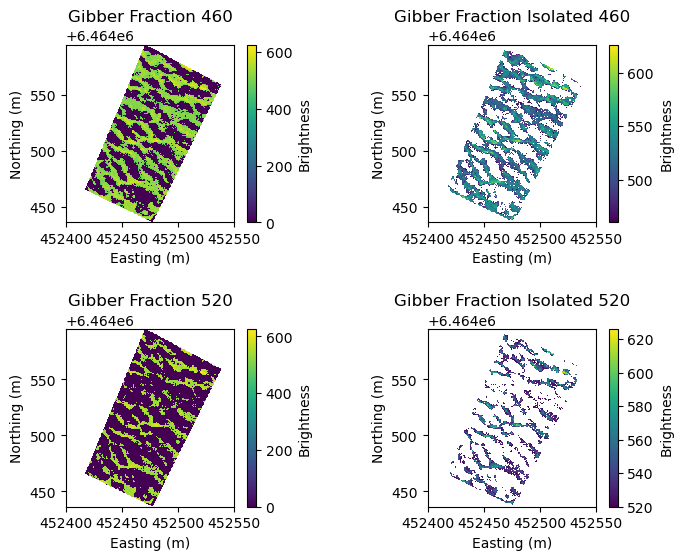

In [28]:
fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(lon_geotiff[::6], lat_geotiff[::6], zero46[::6][:,::6].T)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar(label='Brightness')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.xticks(range(452400, 452551, 50), fontsize=10)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Gibber Fraction 460')

plt.subplot(222)
plt.pcolormesh(lon_geotiff[::6], lat_geotiff[::6], isolate46[::6][:,::6].T)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar(label='Brightness')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.xticks(range(452400, 452551, 50), fontsize=10)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Gibber Fraction Isolated 460')

plt.subplot(223)
plt.pcolormesh(lon_geotiff[::6], lat_geotiff[::6], zero20[::6][:,::6].T)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar(label='Brightness')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.xticks(range(452400, 452551, 50), fontsize=10)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Gibber Fraction 520')

plt.subplot(224)
plt.pcolormesh(lon_geotiff[::6], lat_geotiff[::6], isolate20[::6][:,::6].T)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar(label='Brightness')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.xticks(range(452400, 452551, 50), fontsize=10)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Gibber Fraction Isolated 520')

plt.subplots_adjust(hspace=0.6, wspace=0.4)
fig.set_size_inches(8,6)

plt.savefig('gibber isolated',dpi=300)

In [30]:
maxmin(take3)

(637.0, 56.0)

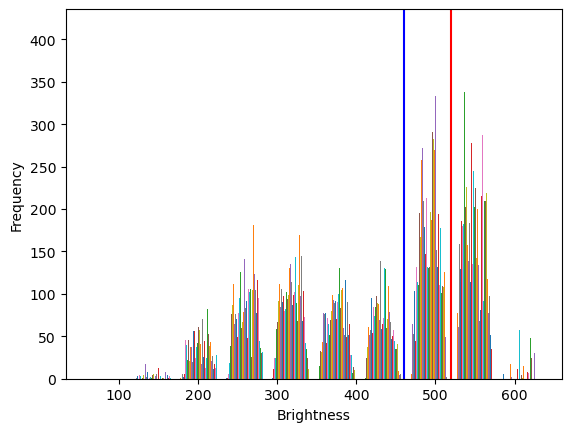

In [31]:
plt.hist(take3)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.axvline(520, color='red')
plt.axvline(460, color='blue')

Error in callback <function _draw_all_if_interactive at 0x000001DA5D3B6AC0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

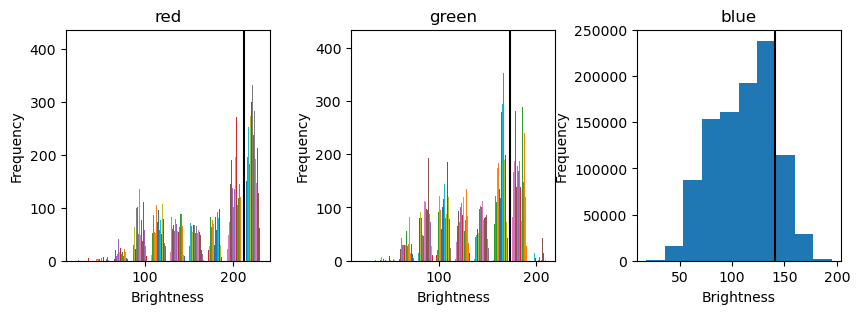

In [37]:
fig = plt.gcf()

plt.subplot(131)
plt.hist(z_r_geotiff)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.axvline(212, color='black')
plt.title('red')

plt.subplot(132)
plt.hist(z_g_geotiff)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.axvline(173, color='black')
plt.title('green')

plt.subplot(133)
plt.hist(z_b_geotiff.flatten())
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.axvline(141, color='black')
plt.title('blue')

plt.subplots_adjust(wspace=0.4)
fig.set_size_inches(10,3)

In [58]:
counts,xbins,ybins = np.histogram2d(z_b_geotiff.flatten(),z_r_geotiff.flatten(),bins=np.arange(256))
counts[counts==0] = np.nan

C:\Users\idaga\AppData\Local\Temp\ipykernel_3524\2877324146.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


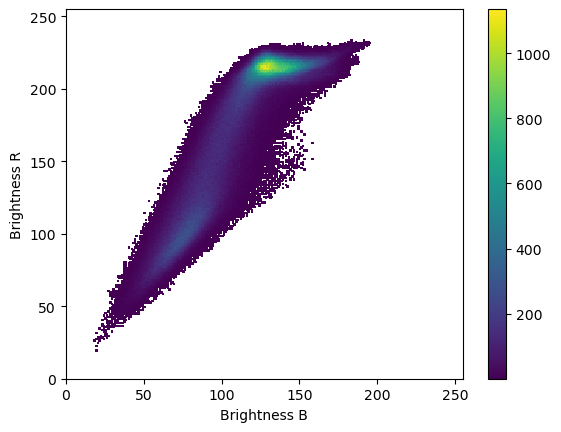

In [59]:
plt.pcolor(xbins,ybins,counts.T)
plt.xlabel('Brightness B')
plt.ylabel('Brightness R')
# plt.axvline(141, color='black')
# plt.title('blue')
plt.colorbar()

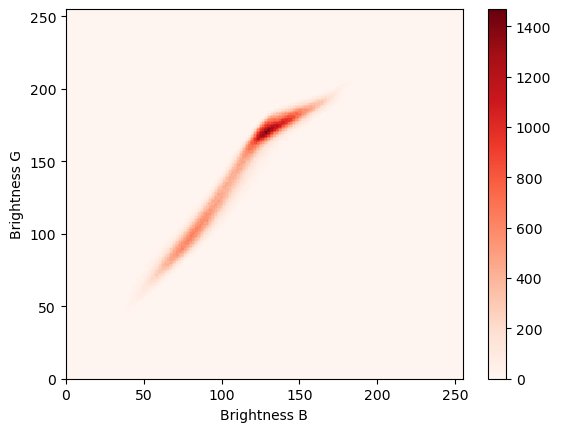

In [53]:
plt.hist2d(z_b_geotiff.flatten(),z_g_geotiff.flatten(),bins=np.arange(256),cmap='Reds')
plt.xlabel('Brightness B')
plt.ylabel('Brightness G')
# plt.axvline(141, color='black')
# plt.title('blue')
plt.colorbar()

Text(0.5, 1.0, 'blue')

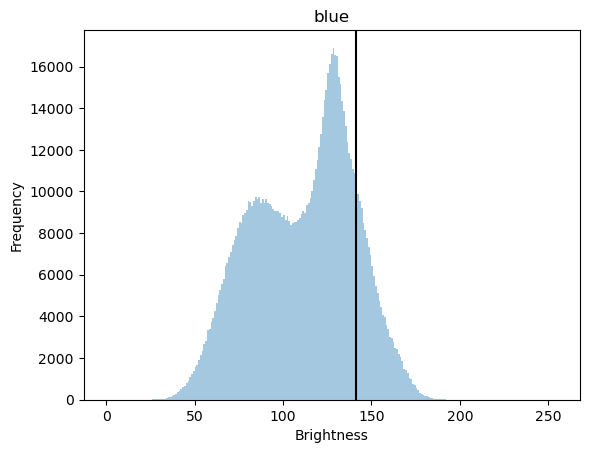

In [49]:
plt.hist(z_b_geotiff[~np.isnan(z_b_geotiff)],bins=np.arange(256),alpha=0.4)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.axvline(141, color='black')
plt.title('blue')

In [33]:
isolatered = brightgib(z_r_geotiff,212)
zerored = zerogib(z_r_geotiff,212)

isolategreen = brightgib(z_g_geotiff,173)
zerogreen = zerogib(z_g_geotiff,173)

isolateblue = brightgib(z_b_geotiff,141)
zeroblue = zerogib(z_b_geotiff,141)

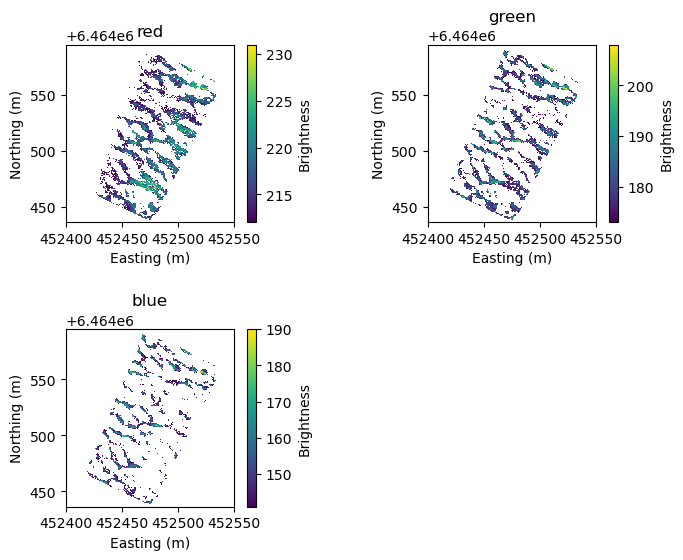

In [36]:
fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(lon_geotiff[::6], lat_geotiff[::6], isolatered[::6][:,::6].T)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar(label='Brightness')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.xticks(range(452400, 452551, 50), fontsize=10)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('red')

plt.subplot(222)
plt.pcolormesh(lon_geotiff[::6], lat_geotiff[::6], isolategreen[::6][:,::6].T)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar(label='Brightness')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.xticks(range(452400, 452551, 50), fontsize=10)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('green')

plt.subplot(223)
plt.pcolormesh(lon_geotiff[::6], lat_geotiff[::6], isolateblue[::6][:,::6].T)
plt.axis('square')
plt.xlim(452400,452550)
plt.colorbar(label='Brightness')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.xticks(range(452400, 452551, 50), fontsize=10)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('blue')

plt.subplots_adjust(hspace=0.6, wspace=0.4)
fig.set_size_inches(8,6)